In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import RMSprop
import keras

from sklearn import datasets, model_selection, preprocessing

import numpy as np

import theano
import theano.tensor as T

import scipy
from scipy.fftpack import fft, ifft

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Comparing numpy and scipy FFT

In [2]:
def numpy_fft(x):
    #numpy doesn't preserve dtype
    return np.fft.fft(np.fft.fft(x)*np.fft.fft(x)).real.astype(np.float32)

def scipy_fft(x):
    #scipy preserves dtype
    return scipy.fftpack.ifft(scipy.fftpack.fft(x)*scipy.fftpack.fft(x)).real

In [3]:
x=np.random.random(size=(1000,1000)).astype(np.float32)

%timeit numpy_fft(x)
%timeit scipy_fft(x)

10 loops, best of 3: 104 ms per loop
10 loops, best of 3: 44.1 ms per loop


## Implementing circulant layer

### Theano forward and gradient operations 

In [4]:
class CirculantConvolutionGradientOp(theano.Op):
    def __init__(self):
        super(CirculantConvolutionGradientOp, self).__init__()

    def make_node(self, r, X, O):
        r = T.as_tensor_variable(r)
        X = T.as_tensor_variable(X)
        O = T.as_tensor_variable(O)

        return theano.Apply(self, [r, X, O], [T.vector(), T.matrix()])

    def perform(self, node, inputs, output_storage):
        
        r = inputs[0]
        X = inputs[1]        
        O = inputs[2]
        
        Offt = fft(O)        

        X_flipped_shifted = np.roll(X[:,::-1],1, axis=1)
        Xfft = fft(X_flipped_shifted)        
        XOconv = ifft(Xfft*Offt).real
        grad_r = np.sum(XOconv, axis=0)
        
        Rfft = fft(r)
        grad_X = ifft(Rfft*Offt).real

        output_storage[0][0] = grad_r
        output_storage[1][0] = grad_X

    def infer_shape(self, node, input_shapes):
        return [input_shapes[0], input_shapes[1]]

In [5]:
class CirculantConvolutionOp(theano.Op):
    def __init__(self):
        super(CirculantConvolutionOp, self).__init__()

    def make_node(self, r, X):
        r = T.as_tensor_variable(r)
        X = T.as_tensor_variable(X)
        
        assert r.ndim == 1
        assert X.ndim == 2
        
        return theano.Apply(self, [r, X], [T.matrix()])

    def perform(self, node, inputs, output_storage):
        r = inputs[0]
        X = inputs[1]
        
        Rfft = fft(r)
        Xfft = fft(X)
        
        result = ifft(Rfft*Xfft).real
        
        output_storage[0][0] = result

    def infer_shape(self, node, input_shapes):
        return [input_shapes[1]]

    def grad(self, inputs, output_grads):
        r = inputs[0]
        X = inputs[1]
        O = output_grads[0]
        
        grad_op = CirculantConvolutionGradientOp()
        return grad_op(r,X, O)

In [6]:
r = T.vector()
X = T.matrix()
conv_op = CirculantConvolutionOp()
f = theano.function([r, X], conv_op(r, X))

print(f([1,2], [[1,2],[1,1],[0,0]]))

[[ 5.  4.]
 [ 3.  3.]
 [ 0.  0.]]


In [7]:
T.verify_grad(conv_op,[np.array([1,2], dtype=np.float32), np.array([[10,2],[1,0],[0,0]], dtype=np.float32)],
                         rng=np.random.RandomState(), n_tests=20)

### Implementing linear layer with circulant weights

In [8]:
class CirculantLayer(Layer):

    def __init__(self, output_dim, fit_intercept=False, **kwargs):
        self.output_dim = output_dim
        self.fit_intercept = fit_intercept
        super(CirculantLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.sign_flipping = np.random.randint(0,2, size = input_shape[1])
        self.sign_flipping = (self.sign_flipping*2-1).astype(np.float32)
        self.sign_flipping = K.T.as_tensor_variable(self.sign_flipping)
        
        self.input_dim = input_shape[1]
        
        circulant_vec_shape = (self.input_dim,)
        if self.input_dim<self.output_dim:
            circulant_vec_shape = (self.output_dim,)
        
        self.circulant_vec = self.add_weight(name='circulant_vec', 
                                      shape=circulant_vec_shape,
                                      initializer='uniform',
                                      trainable=True)     
        
        if self.fit_intercept:
            self.bias = self.add_weight(name='bias', 
                                      shape=(self.output_dim,),
                                      initializer='uniform',
                                      trainable=True)
        
        super(CirculantLayer, self).build(input_shape) 

    def call(self, X):
        X =  self.sign_flipping * X  
        
        if self.input_dim<self.output_dim:
            zeros = K.T.zeros((X.shape[0], self.output_dim))
            X = K.T.set_subtensor(zeros[:,:self.input_dim], X)
        
        r = self.circulant_vec

        conv_op = CirculantConvolutionOp()
        RX =conv_op(r, X)
        
        if self.input_dim>self.output_dim:
            RX = RX[:, :self.output_dim]
        
        if self.fit_intercept:
            RX = RX + self.bias
        
        return RX

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

## Testing on digits dataset

In [9]:
def model_memory(model):
    return sum(w.nbytes for w in model.get_weights())

In [12]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
le = preprocessing.OneHotEncoder()
y = le.fit_transform(digits.target.reshape(-1, 1)).todense()

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
def fit_circulant_digits():
    model = Sequential()
    model.add(CirculantLayer(1000, input_shape=[X.shape[1]]))
    model.add(Activation('relu'))
    model.add(CirculantLayer(1000))
    model.add(Activation('relu'))
    model.add(CirculantLayer(10))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, verbose = 0)
    return model

In [15]:
def fit_dense_digits():
    model = Sequential()
    model.add(Dense(1000, input_shape=[X.shape[1]]))
    model.add(Activation('relu'))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, verbose=0)
    return model

In [16]:
%timeit -n 10 fit_dense_digits()

10 loops, best of 3: 7.92 s per loop


In [17]:
%timeit -n 10 fit_circulant_digits()

10 loops, best of 3: 4.94 s per loop


In [18]:
circulant_model = fit_circulant_digits()

In [19]:
dense_model = fit_dense_digits()

In [20]:
%timeit dense_model.predict(X_test)

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 33.7 ms per loop


In [21]:
%timeit circulant_model.predict(X_test)

The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 56.2 ms per loop


In [22]:
model_memory(dense_model)/model_memory(circulant_model)

358.67

In [23]:
dense_model.evaluate(X_test, y_test)

 32/594 [>.............................] - ETA: 0s

[0.056658413350544494, 0.98653198653198648]

In [24]:
circulant_model.evaluate(X_test, y_test)

352/594 [================>.............] - ETA: 0s

[0.1273461569238592, 0.97306397306397308]

## Testing on MNIST dataset

In [43]:
from keras.datasets import mnist

In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [45]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [46]:
batch_size = 128
num_classes = 10
epochs = 20

In [47]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [48]:
def fit_model_mnist(Layer, x_train, y_train, dense_layer_size=512) :
    model = Sequential()
    model.add(Layer(dense_layer_size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(dense_layer_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(num_classes))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    start = time.time()
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,)
    end = time.time()

    print(end - start,'s')
    return model


In [49]:
dense_model = fit_model_mnist(Dense, x_train, y_train)

Epoch 1/20
 - 9s - loss: 0.2463 - acc: 0.9247
Epoch 2/20
 - 9s - loss: 0.1017 - acc: 0.9685
Epoch 3/20
 - 10s - loss: 0.0748 - acc: 0.9781
Epoch 4/20
 - 10s - loss: 0.0598 - acc: 0.9822
Epoch 5/20
 - 10s - loss: 0.0506 - acc: 0.9848
Epoch 6/20
 - 10s - loss: 0.0427 - acc: 0.9871
Epoch 7/20
 - 10s - loss: 0.0375 - acc: 0.9888
Epoch 8/20
 - 10s - loss: 0.0354 - acc: 0.9897
Epoch 9/20
 - 11s - loss: 0.0305 - acc: 0.9914
Epoch 10/20
 - 11s - loss: 0.0283 - acc: 0.9921
Epoch 11/20
 - 11s - loss: 0.0276 - acc: 0.9919
Epoch 12/20
 - 11s - loss: 0.0254 - acc: 0.9925
Epoch 13/20
 - 11s - loss: 0.0249 - acc: 0.9935
Epoch 14/20
 - 11s - loss: 0.0245 - acc: 0.9934
Epoch 15/20
 - 11s - loss: 0.0215 - acc: 0.9943
Epoch 16/20
 - 11s - loss: 0.0189 - acc: 0.9949
Epoch 17/20
 - 11s - loss: 0.0198 - acc: 0.9947
Epoch 18/20
 - 11s - loss: 0.0200 - acc: 0.9952
Epoch 19/20
 - 11s - loss: 0.0212 - acc: 0.9949
Epoch 20/20
 - 11s - loss: 0.0213 - acc: 0.9945
211.4985761642456 s


In [50]:
circulant_model  = fit_model_mnist(CirculantLayer, x_train, y_train)

Epoch 1/20
 - 16s - loss: 1.0468 - acc: 0.6646
Epoch 2/20
 - 16s - loss: 0.6338 - acc: 0.7952
Epoch 3/20
 - 16s - loss: 0.5750 - acc: 0.8160
Epoch 4/20
 - 16s - loss: 0.5417 - acc: 0.8292
Epoch 5/20
 - 16s - loss: 0.5271 - acc: 0.8342
Epoch 6/20
 - 16s - loss: 0.5233 - acc: 0.8362
Epoch 7/20
 - 16s - loss: 0.5159 - acc: 0.8395
Epoch 8/20
 - 16s - loss: 0.5113 - acc: 0.8376
Epoch 9/20
 - 16s - loss: 0.5055 - acc: 0.8403
Epoch 10/20
 - 16s - loss: 0.5017 - acc: 0.8429
Epoch 11/20
 - 16s - loss: 0.4964 - acc: 0.8434
Epoch 12/20
 - 16s - loss: 0.4940 - acc: 0.8462
Epoch 13/20
 - 16s - loss: 0.4915 - acc: 0.8450
Epoch 14/20
 - 16s - loss: 0.4906 - acc: 0.8464
Epoch 15/20
 - 16s - loss: 0.4868 - acc: 0.8469
Epoch 16/20
 - 16s - loss: 0.4871 - acc: 0.8488
Epoch 17/20
 - 16s - loss: 0.4841 - acc: 0.8489
Epoch 18/20
 - 16s - loss: 0.4790 - acc: 0.8537
Epoch 19/20
 - 16s - loss: 0.4754 - acc: 0.8521
Epoch 20/20
 - 16s - loss: 0.4785 - acc: 0.8508
318.8497567176819 s


In [51]:
dense_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 165us/step


[0.096258650681470839, 0.98440000000000005]

In [52]:
circulant_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 150us/step


[0.28823059252500532, 0.91790000000000005]

In [53]:
model_memory(dense_model)/model_memory(circulant_model)

370.41261061946904

In [43]:
def compute_stats(Layer, size):
    start = time.time()
    model = Sequential()
    model.add(Layer(size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(size))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=1,
                        verbose=0,)
    end = time.time()

    return end - start, model_memory(model)


In [44]:
layer_sizes= [256, 512, 1024, 2048, 3072]
dense_stats = [compute_stats(Dense, size) for size in tqdm_notebook(layer_sizes)]
circulant_stats = [compute_stats(CirculantLayer, size) for size in tqdm_notebook(layer_sizes)]



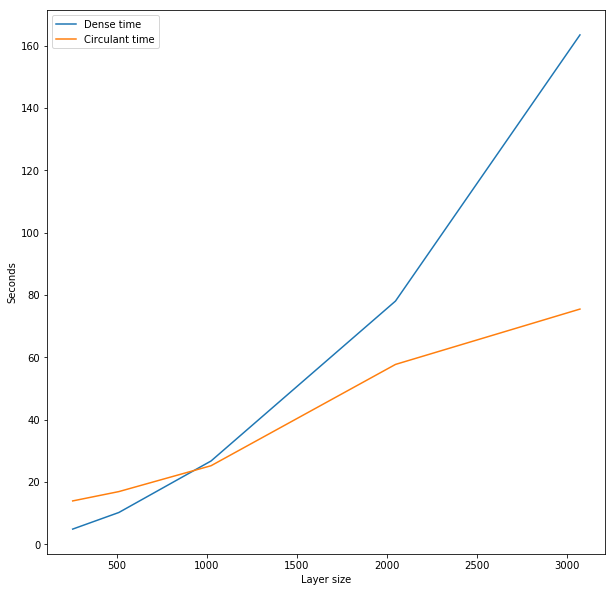

In [62]:
dense_times = list(map(lambda x:x[0], dense_stats))
circulant_times = list(map(lambda x:x[0], circulant_stats))

dense_memory = np.array(list(map(lambda x:x[1], dense_stats)))
circulant_memory = np.array(list(map(lambda x:x[1], circulant_stats)))

plt.plot(layer_sizes, dense_times, label="Dense time")
plt.plot(layer_sizes, circulant_times, label="Circulant time")
plt.xlabel("Layer size")
plt.ylabel("Seconds")
plt.legend()

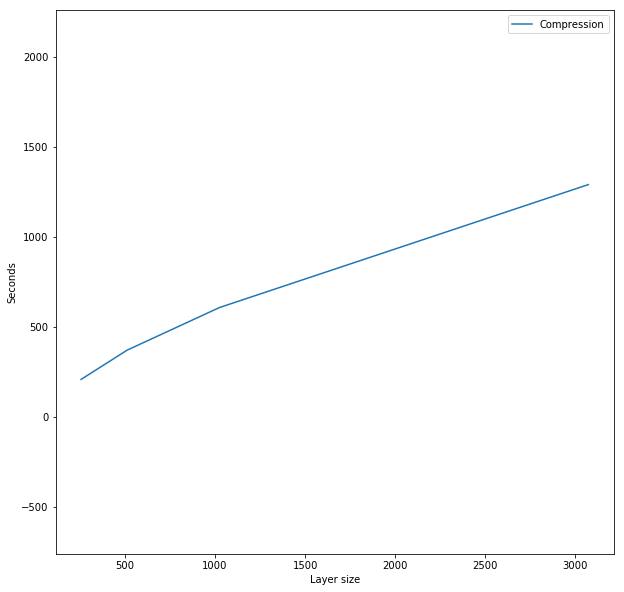

In [63]:
plt.plot(layer_sizes, dense_memory/circulant_memory,  label="Compression")

plt.xlabel("Layer size")
plt.ylabel("Seconds")
plt.axis('equal')
plt.legend()

## Testing on Fashion MNIST dataset

In [24]:
from keras.datasets import fashion_mnist 

In [25]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [26]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [27]:
batch_size = 128
num_classes = 10
epochs = 20

In [28]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [35]:
dense_model = fit_model_mnist(Dense, x_train, y_train)

Epoch 1/20
 - 9s - loss: 0.5604 - acc: 0.7969
Epoch 2/20
 - 9s - loss: 0.4025 - acc: 0.8512
Epoch 3/20
 - 9s - loss: 0.3674 - acc: 0.8660
Epoch 4/20
 - 11s - loss: 0.3496 - acc: 0.8729
Epoch 5/20
 - 11s - loss: 0.3390 - acc: 0.8778
Epoch 6/20
 - 10s - loss: 0.3282 - acc: 0.8824
Epoch 7/20
 - 11s - loss: 0.3194 - acc: 0.8857
Epoch 8/20
 - 12s - loss: 0.3134 - acc: 0.8872
Epoch 9/20
 - 11s - loss: 0.3075 - acc: 0.8906
Epoch 10/20
 - 10s - loss: 0.3044 - acc: 0.8917
Epoch 11/20
 - 10s - loss: 0.3013 - acc: 0.8940
Epoch 12/20
 - 11s - loss: 0.2955 - acc: 0.8961
Epoch 13/20
 - 12s - loss: 0.2936 - acc: 0.8969
Epoch 14/20
 - 11s - loss: 0.2920 - acc: 0.8982
Epoch 15/20
 - 11s - loss: 0.2853 - acc: 0.9007
Epoch 16/20
 - 11s - loss: 0.2850 - acc: 0.8998
Epoch 17/20
 - 11s - loss: 0.2812 - acc: 0.9020
Epoch 18/20
 - 10s - loss: 0.2816 - acc: 0.9021
Epoch 19/20
 - 10s - loss: 0.2765 - acc: 0.9040
Epoch 20/20
 - 11s - loss: 0.2771 - acc: 0.9041
213.3881950378418 s


In [36]:
circulant_model  = fit_model_mnist(CirculantLayer, x_train, y_train)

Epoch 1/20
 - 16s - loss: 1.0431 - acc: 0.6300
Epoch 2/20
 - 17s - loss: 0.7266 - acc: 0.7438
Epoch 3/20
 - 16s - loss: 0.6840 - acc: 0.7599
Epoch 4/20
 - 16s - loss: 0.6570 - acc: 0.7685
Epoch 5/20
 - 16s - loss: 0.6422 - acc: 0.7718
Epoch 6/20
 - 16s - loss: 0.6338 - acc: 0.7772
Epoch 7/20
 - 16s - loss: 0.6257 - acc: 0.7795
Epoch 8/20
 - 17s - loss: 0.6159 - acc: 0.7821
Epoch 9/20
 - 16s - loss: 0.6150 - acc: 0.7828
Epoch 10/20
 - 16s - loss: 0.6119 - acc: 0.7837
Epoch 11/20
 - 15s - loss: 0.6110 - acc: 0.7829
Epoch 12/20
 - 15s - loss: 0.6036 - acc: 0.7870
Epoch 13/20
 - 16s - loss: 0.6014 - acc: 0.7857
Epoch 14/20
 - 15s - loss: 0.5994 - acc: 0.7869
Epoch 15/20
 - 15s - loss: 0.5987 - acc: 0.7880
Epoch 16/20
 - 15s - loss: 0.5963 - acc: 0.7867
Epoch 17/20
 - 15s - loss: 0.5966 - acc: 0.7874
Epoch 18/20
 - 15s - loss: 0.5975 - acc: 0.7864
Epoch 19/20
 - 15s - loss: 0.5917 - acc: 0.7904
Epoch 20/20
 - 16s - loss: 0.5940 - acc: 0.7894
316.397096157074 s


In [37]:
dense_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 121us/step


[0.39134998852610586, 0.8891]

In [38]:
circulant_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 142us/step


[0.50948777799606326, 0.81940000000000002]

In [41]:
model_memory(dense_model)/model_memory(circulant_model)

370.41261061946904

In [39]:
circulant_model_2048  = fit_model_mnist(CirculantLayer, x_train, y_train, dense_layer_size=2048)

Epoch 1/20
 - 51s - loss: 0.8803 - acc: 0.6979
Epoch 2/20
 - 50s - loss: 0.6204 - acc: 0.7833
Epoch 3/20
 - 50s - loss: 0.5810 - acc: 0.7945
Epoch 4/20
 - 52s - loss: 0.5567 - acc: 0.8022
Epoch 5/20
 - 53s - loss: 0.5385 - acc: 0.8091
Epoch 6/20
 - 49s - loss: 0.5297 - acc: 0.8102
Epoch 7/20
 - 49s - loss: 0.5187 - acc: 0.8151
Epoch 8/20
 - 53s - loss: 0.5125 - acc: 0.8172
Epoch 9/20
 - 51s - loss: 0.5098 - acc: 0.8184
Epoch 10/20
 - 51s - loss: 0.5076 - acc: 0.8190
Epoch 11/20
 - 51s - loss: 0.5023 - acc: 0.8197
Epoch 12/20
 - 50s - loss: 0.5029 - acc: 0.8198
Epoch 13/20
 - 51s - loss: 0.5018 - acc: 0.8216
Epoch 14/20
 - 50s - loss: 0.4960 - acc: 0.8227
Epoch 15/20
 - 51s - loss: 0.4981 - acc: 0.8215
Epoch 16/20
 - 51s - loss: 0.4979 - acc: 0.8238
Epoch 17/20
 - 50s - loss: 0.4956 - acc: 0.8232
Epoch 18/20
 - 50s - loss: 0.4959 - acc: 0.8232
Epoch 19/20
 - 50s - loss: 0.4951 - acc: 0.8229
Epoch 20/20
 - 50s - loss: 0.4942 - acc: 0.8233
1015.1714026927948 s


In [40]:
circulant_model_2048.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 424us/step


[0.42839059092998505, 0.8458]

In [42]:
model_memory(dense_model)/model_memory(circulant_model_2048)

109.00162760416667